# Tidymodels

- This notebook uses local R kernel
- This notebook is based on [Tutorial on tidymodels for Machine Learning](https://hansjoerg.me/2020/02/09/tidymodels-for-machine-learning/)


## Install Packages

In [ ]:
# ## install packages
# install.packages('conflicted')
# install.pakcages('tidymodels')

In [13]:
library(conflicted)
library(tidymodels)
library("ggrepel")     # for geom_label_repel()
library("corrplot")    # for corrplot()
conflict_prefer("filter", "dplyr")

corrplot 0.84 loaded

[conflicted] Will prefer dplyr::filter over any other package



## Data

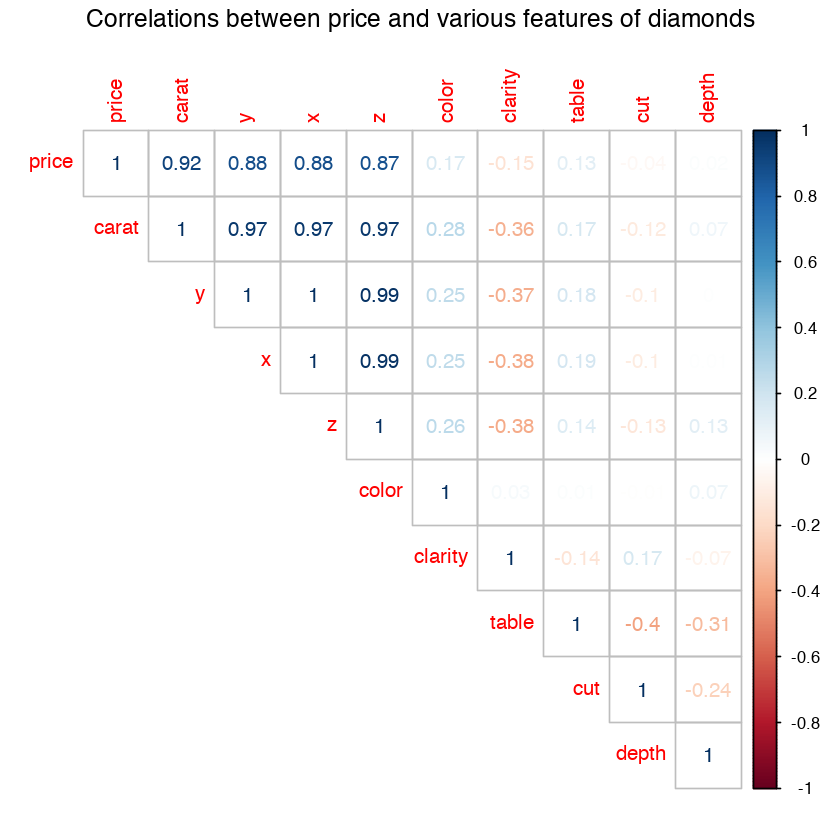

In [15]:
data("diamonds")

diamonds %>%
    sample_n(2000) %>%
    mutate_if(is.factor, as.numeric) %>%
    select(price, everything()) %>%
    cor %>%
    {.[order(abs(.[, 1]), decreasing = TRUE), 
       order(abs(.[, 1]), decreasing = TRUE)]} %>%
    corrplot(method = "number", type = "upper", mar = c(0, 0, 1.5, 0),
             title = "Correlations between price and various features of diamonds")

## Train-Test Split

- `rsample` package
- train-test split based on 0.1 proportion
- 3-fold cross-validation for train

In [ ]:
set.seed(1243)

dia_split <- initial_split(diamonds, prop = .1, strata = price)

dia_train <- training(dia_split)
dia_test  <- testing(dia_split)

dim(dia_train)

dim(dia_test)


dia_vfold <- vfold_cv(dia_train, v = 3, repeats = 1, strata = price)
dia_vfold %>% 
  mutate(df_ana = map(splits, analysis),
         df_ass = map(splits, assessment))-> dia_vfold

## Data Pre-Processing and Feature Engineering

- `recipes` library

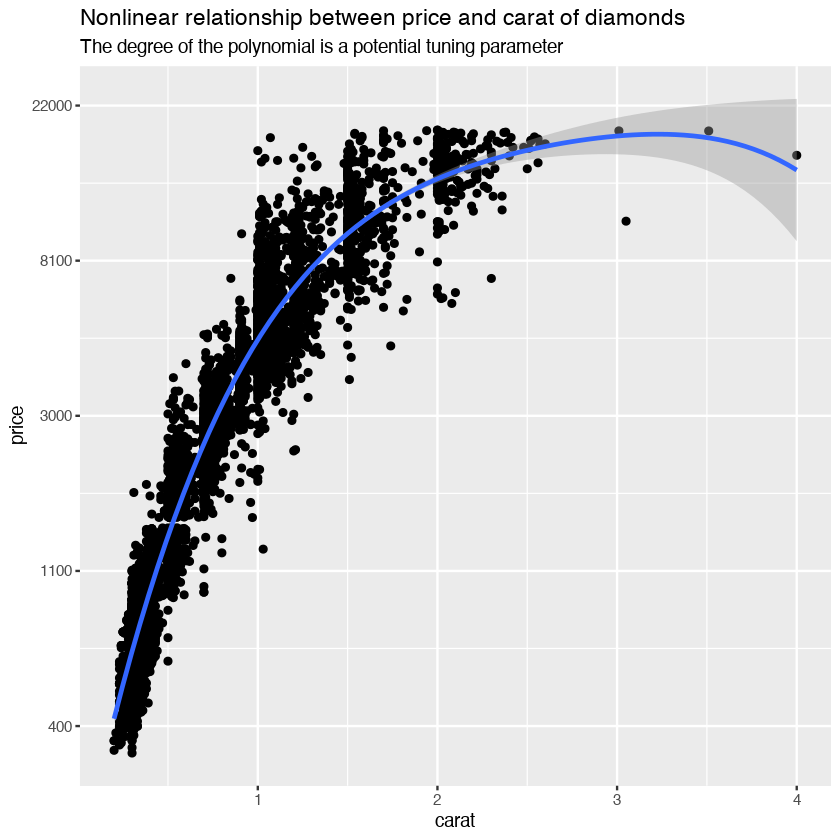

In [17]:
qplot(carat, price, data = dia_train) +
    scale_y_continuous(trans = log_trans(), labels = function(x) round(x, -2)) +
    geom_smooth(method = "lm", formula = "y ~ poly(x, 4)") +
    labs(title = "Nonlinear relationship between price and carat of diamonds",
         subtitle = "The degree of the polynomial is a potential tuning parameter")

In [18]:
dia_rec <-
    recipe(price ~ ., data = dia_train) %>%
    step_log(all_outcomes()) %>%
    step_normalize(all_predictors(), -all_nominal()) %>%
    step_dummy(all_nominal()) %>%
    step_poly(carat, degree = 2)

prep(dia_rec)

Data Recipe

Inputs:

      role #variables
   outcome          1
 predictor          9

Training data contained 5395 data points and no missing data.

Operations:

Log transformation on price [trained]
Centering and scaling for carat, depth, table, x, y, z [trained]
Dummy variables from cut, color, clarity [trained]
Orthogonal polynomials on carat [trained]

In [19]:
dia_juiced <- juice(prep(dia_rec))
dim(dia_juiced)

names(dia_juiced)

[1] 5395   25

[1] "depth"        "table"        "x"            "y"            "z"           
 [6] "price"        "cut_1"        "cut_2"        "cut_3"        "cut_4"       
[11] "color_1"      "color_2"      "color_3"      "color_4"      "color_5"     
[16] "color_6"      "clarity_1"    "clarity_2"    "clarity_3"    "clarity_4"   
[21] "clarity_5"    "clarity_6"    "clarity_7"    "carat_poly_1" "carat_poly_2"

## Model

- `parsnip` library

In [20]:
lm_model <-
    linear_reg() %>%
    set_mode("regression") %>%
    set_engine("lm")

In [21]:
rand_forest(mtry = 3, trees = 500, min_n = 5) %>%
    set_mode("regression") %>%
    set_engine("ranger", importance = "impurity_corrected")

Random Forest Model Specification (regression)

Main Arguments:
  mtry = 3
  trees = 500
  min_n = 5

Engine-Specific Arguments:
  importance = impurity_corrected

Computational engine: ranger 


In [22]:
lm_fit1 <- fit(lm_model, price ~ ., dia_juiced)
lm_fit1

parsnip model object

Fit time:  10ms 

Call:
stats::lm(formula = price ~ ., data = data)

Coefficients:
 (Intercept)         depth         table             x             y  
    7.711965      0.010871      0.005889      0.251155      0.054422  
           z         cut_1         cut_2         cut_3         cut_4  
    0.054196      0.106701     -0.026356      0.024207     -0.006191  
     color_1       color_2       color_3       color_4       color_5  
   -0.455831     -0.084108     -0.004810      0.009725     -0.005591  
     color_6     clarity_1     clarity_2     clarity_3     clarity_4  
   -0.009730      0.860961     -0.242698      0.132234     -0.052903  
   clarity_5     clarity_6     clarity_7  carat_poly_1  carat_poly_2  
    0.028996      0.002403      0.022235     51.663971    -17.508316  


## Summarizing Models

- `broom` library
    - `glance()`: summary of the model
    - `tidy()`: model parameters
    - `augment()`: model predictions

In [23]:
glance(lm_fit1$fit)

r.squared adj.r.squared sigma     statistic p.value df logLik  AIC     
1 0.9772398 0.977138      0.1538002 9606.989  0       24 2457.34 -4862.68
  BIC       deviance df.residual nobs
1 -4691.256 127.0247 5370        5395

In [24]:
tidy(lm_fit1) %>% 
  arrange(desc(abs(statistic)))

term         estimate      std.error   statistic    p.value     
1  (Intercept)    7.711965177 0.004309244 1789.6329736 0.000000e+00
2  carat_poly_2 -17.508315597 0.258613253  -67.7007670 0.000000e+00
3  clarity_1      0.860960954 0.013453560   63.9950282 0.000000e+00
4  color_1       -0.455831036 0.007376765  -61.7928101 0.000000e+00
5  carat_poly_1  51.663971041 1.098640865   47.0253499 0.000000e+00
6  clarity_2     -0.242697885 0.012670018  -19.1552909 3.632062e-79
7  color_2       -0.084108400 0.006647035  -12.6535205 3.498397e-36
8  clarity_3      0.132233776 0.010747757   12.3033835 2.509490e-34
9  cut_1          0.106701157 0.009972380   10.6996678 1.883900e-26
10 clarity_4     -0.052902688 0.008393015   -6.3031807 3.148671e-10
11 x              0.251154596 0.041825863    6.0047678 2.041808e-09
12 clarity_5      0.028995894 0.006758759    4.2901210 1.817125e-05
13 clarity_7      0.022235283 0.005262320    4.2253762 2.424947e-05
14 cut_3          0.024207427 0.006866142    3.5256228 4.260138e-04
15 cut_2         -0.026355864 0.008046538   -3.2754290 1.061709e-03
16 depth          0.010870675 0.004672369    2.3265876 2.002424e-02
17 table          0.005888728 0.002829098    2.0814857 3.743672e-02
18 color_6       -0.009729818 0.005003565   -1.9445769 5.187806e-02
19 z              0.054196202 0.031573960    1.7164842 8.613114e-02
20 color_4        0.009724747 0.005838323    1.6656747 9.583655e-02
21 cut_4         -0.006190584 0.005406221   -1.1450851 2.522249e-01
22 y              0.054422266 0.047973242    1.1344296 2.566650e-01
23 color_5       -0.005591257 0.005588065   -1.0005712 3.170792e-01
24 color_3       -0.004810296 0.006310898   -0.7622205 4.459619e-01
25 clarity_6      0.002402715 0.005891533    0.4078251 6.834184e-01

In [25]:
lm_predicted <- augment(lm_fit1$fit, data = dia_juiced) %>% 
    rowid_to_column()
select(lm_predicted, rowid, price, .fitted:.std.resid)

rowid price    .fitted  .resid        .std.resid  
1     1    5.826000 5.902853 -0.0768529622 -0.501563773
2     2    5.843544 5.796385  0.0471590900  0.307406182
3     3    5.860786 5.889359 -0.0285732169 -0.186529832
4     4    5.877736 6.237495 -0.3597592843 -2.343973613
5     5    5.996452 6.240711 -0.2442588066 -1.591807360
6     6    5.998937 6.060439 -0.0615027963 -0.400743931
7     7    5.998937 6.098803 -0.0998667352 -0.651023652
8     8    5.998937 6.055522 -0.0565855591 -0.368763840
9     9    6.001415 6.217837 -0.2164224247 -1.409555947
10   10    6.315358 6.548270 -0.2329120546 -1.516820403
11   11    6.315358 6.560218 -0.2448602475 -1.595672418
12   12    6.315358 6.318416 -0.0030579836 -0.019914979
13   13    6.315358 6.559586 -0.2442279383 -1.592136322
14   14    6.317165 6.163955  0.1532095699  0.997941409
15   15    6.317165 6.183923  0.1332414223  0.867816425
16   16    6.317165 6.588747 -0.2715822135 -1.770099219
17   17    7.923710 7.748697  0.1750130469  1.143203350
18   18    7.924796 7.941637 -0.0168409524 -0.109709110
19   19    7.925880 7.893599  0.0322810172  0.210269387
20   20    7.925880 7.685431  0.2404493845  1.565722372
21   21    7.926242 7.584869  0.3413727888  2.223103781
22   22    7.927324 7.820591  0.1067329287  0.695015809
23   23    7.928766 7.723847  0.2049197533  1.333966742
24   24    7.929126 7.854521  0.0746053164  0.485694355
25   25    7.929126 7.780904  0.1482222749  0.964938546
26   26    7.929126 7.804653  0.1244730743  0.810590942
27   27    7.929126 7.883319  0.0458079116  0.298486543
28   28    7.929126 7.930010 -0.0008833026 -0.005749965
29   29    7.934872 7.898407  0.0364649884  0.237422651
30   30    7.935230 8.012199 -0.0769691455 -0.501202308
⋮    ⋮     ⋮        ⋮        ⋮             ⋮           
5366 5366  7.905073 7.935647 -0.0305743365 -0.199059165
5367 5367  7.905073 7.934320 -0.0292472796 -0.190516451
5368 5368  7.905810 7.750838  0.1549723733  1.009279268
5369 5369  7.905810 7.744023  0.1617873492  1.053915669
5370 5370  7.906179 7.850824  0.0553547483  0.360758938
5371 5371  7.906547 7.806318  0.1002290078  0.652527284
5372 5372  7.907284 7.645613  0.2616703992  1.706014347
5373 5373  7.907284 7.890339  0.0169441292  0.110286875
5374 5374  7.908019 7.879622  0.0283975783  0.184872436
5375 5375  7.909857 7.913872 -0.0040156778 -0.026139236
5376 5376  7.911324 7.819681  0.0916426812  0.596508075
5377 5377  7.911691 7.797380  0.1143103236  0.745485280
5378 5378  7.912057 7.747436  0.1646206435  1.071716389
5379 5379  7.912057 8.027158 -0.1151009642 -0.749665916
5380 5380  7.912789 7.962325 -0.0495360979 -0.322642457
5381 5381  7.912789 7.904985  0.0078040246  0.050815636
5382 5382  7.913155 7.555532  0.3576232379  2.328948250
5383 5383  7.913521 7.813292  0.1002289852  0.652694279
5384 5384  7.913887 7.951702 -0.0378151685 -0.246277798
5385 5385  7.913887 7.914825 -0.0009378648 -0.006107237
5386 5386  7.914618 7.825823  0.0887945178  0.578490753
5387 5387  7.914618 8.066042 -0.1514238922 -0.986045878
5388 5388  7.914983 8.062599 -0.1476159101 -0.961917984
5389 5389  7.916807 7.509935  0.4068728228  2.649946413
5390 5390  7.917172 7.696423  0.2207488354  1.436961809
5391 5391  7.917536 8.190003 -0.2724668849 -1.779162450
5392 5392  7.918992 7.669926  0.2490664782  1.624936384
5393 5393  7.918992 7.797190  0.1218023789  0.792948781
5394 5394  7.920447 7.600509  0.3199379737  2.083210535
5395 5395  7.921536 7.745220  0.1763153338  1.148070602

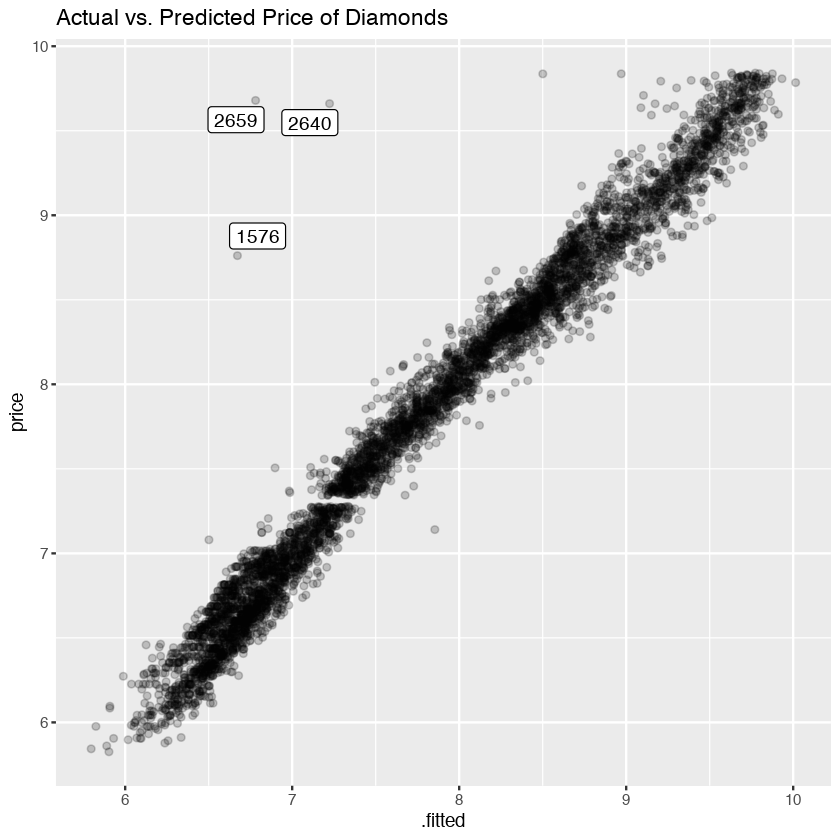

In [26]:
ggplot(lm_predicted, aes(.fitted, price)) +
    geom_point(alpha = .2) +
    ggrepel::geom_label_repel(aes(label = rowid), 
                              data = filter(lm_predicted, abs(.resid) > 2)) +
    labs(title = "Actual vs. Predicted Price of Diamonds")

## Evaluating Model Performance

- `yardstick` library
- cross-validation of model performance using `rsample`, `parsnip`, and `yardstick`

In [27]:
# How does dia_vfold look?
dia_vfold

splits                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          